## SYDE556/750 Assignment 2: Spiking Neurons

- Due Date: Feb 15th: Assignment #2 (due at midnight) 
- Total marks: 20 (20% of final grade)
- Late penalty: 1 mark per day
- It is recommended that you Python.
- *Do not use any code from Nengo*

## 1) Generating a random input signal

### 1.1) Gaussian white noise

Create a function called that generates a randomly varying $x(t)$ signal chosen from a white noise distribution.  Call it 'generate_signal' and ensure that it returns $x(t)$ and $X(\omega)$.

The inputs to the function are:

- ``T``: the length of the signal in seconds
- ``dt``: the time step in seconds
- ``rms``: the root mean square power level of the signal.  That is, the resulting signal should have $\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$
- ``limit``: the maximum frequency for the signal (in Hz)
- ``seed``: the random number seed to use (so we can regenerate the same signal again)

Notes:

- To do Fourier transforms in MATLAB, see [here](http://www.mathworks.com/help/matlab/ref/fft.html)
- To do Fourier transforms in Python, see [here](http://docs.scipy.org/doc/numpy/reference/routines.fft.html)    
- In both cases, the transform takes you from $t$ to $\omega$ (or back the other way).  Importantly, $\omega$ is frequency in *radians*, not in Hz.  
- $\Delta \omega$ will be $2 \pi / T$
- To keep the signal real, $X(\omega)=X(-\omega)^*$ (the complex conjugate: the real parts are equal, and the imaginary parts switch sign)
- When randomly generating $X(\omega)$ values, sample them from a Normal distribution $N(\mu=0,\sigma=1)$.  Remember that these are complex numbers, so sample twice from the distribution; once for the real component and once for the imaginary.
- To implement the ``limit``, set all $X(\omega)$ components with frequencies above the limit to 0
- To implement the ``rms``, generate the signal, compute its RMS power ($\sqrt{{1 \over T} \int{x(t)^2}dt}=rms$) and rescale so it has the desired power.

1. [1 mark] Plot $x(t)$ for three randomly generated signals with ``limit`` at 5, 10, and 20Hz. For each of these, ``T``=1, ``dt``=0.001, and ``rms``=0.5.

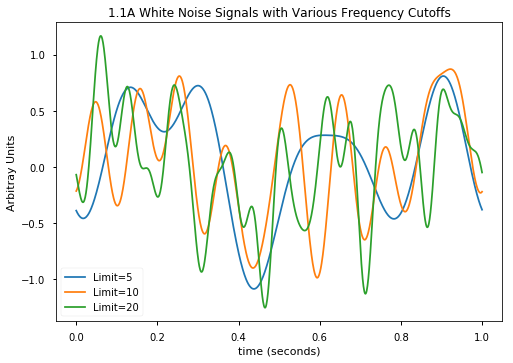

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook') # awesome


def getRMS(sig):
    return np.sqrt(1/float(len(sig)) * np.sum(sig**2))

def calc_rms(x):
    '''Calculate root mean squared power of a signal x'''
    return np.sqrt(np.mean(np.power(x,2)))

# doing it this way give the same result
def generate_signal(T, dt, rms, limit, seed=0):
    
    np.random.seed(seed=seed)
    
    t = np.arange(0,T,dt) #time scale
    N = int(T/dt) #samples
    f = np.fft.fftfreq(N,dt) #freq range (Hz)
    X = np.zeros(len(f)).tolist() #freq signal
    
    for i, freq in enumerate(f):
        if abs(freq) <= limit: #skip for freqs past limit
            real, imag = np.random.normal(), np.random.normal()*1j
            X[i] = real + imag
            if -freq in f and freq != 0: #symmetric values
                X[i] = real - imag
       
    x = np.fft.ifft(X).real
    sig_rms = calc_rms(x)

    x = [sig*rms/(sig_rms) for sig in x]
    X = np.fft.fft(x)

    return x,X
 
T = 1
dt = 0.001
N = int(T/dt)
rms = 0.5
time = np.linspace(0, T, N)

# limits 5, 10, 20
x5, _ = generate_signal(T, dt, rms, 5, seed=5)
x10, _ = generate_signal(T, dt, rms, 10, seed=5)
x20, _ = generate_signal(T, dt, rms, 20, seed=5)


plt.figure()
plt.plot(time, x5, label='Limit=5')
plt.plot(time, x10, label='Limit=10')
plt.plot(time, x20, label='Limit=20')
plt.xlabel('time (seconds)')
plt.ylabel('Arbitray Units')
plt.title('1.1A White Noise Signals with Various Frequency Cutoffs')
plt.legend()

2. [1 mark] Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=10 (each of these 100 signals should have a different ``seed``). The plot should have the x-axis labeled ($\omega$ in radians) and the average $|X|$ value for that $\omega$ on the y-axis.

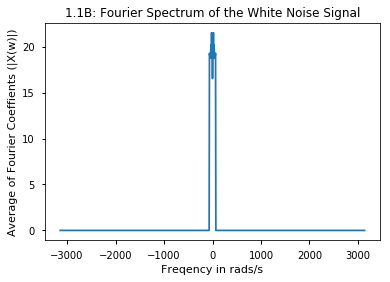

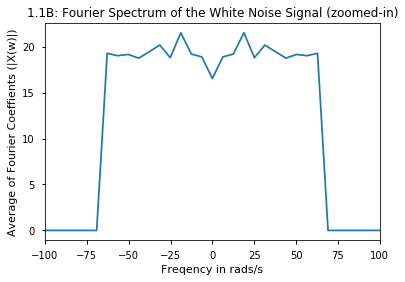

In [2]:
# time ranges and params
num_seeds = 100
t = np.arange(0, T, dt)
N = len(t) #samples
T, dt, rms, limit = 1, 0.001, 0.1, 10

f = sorted(np.fft.fftfreq(N,dt)) #freqs (Hz)
w = [2*np.pi*freq for freq in f] #convert to radians

seeds = np.arange(1,num_seeds,1) #100 unique PRNG seeds

fourier_coefficients = np.zeros((N, 100))
X_sigs = []
for seed in seeds:
    x,X = generate_signal(T=T,dt=dt,rms=rms,limit=limit,seed=seed)
    X_sigs.append(X)
    fourier_coefficients[:, seed] = np.abs(X)
    
    
mean_fourier_coeffients = np.mean(fourier_coefficients, axis=1)

X_sigs = np.array(X_sigs)
X_sigs_norm = [np.absolute(freq_vals) for freq_vals in X_sigs[:,]][0]

plt.figure()
plt.plot(w, np.fft.fftshift(mean_fourier_coeffients))
plt.xlabel('Freqency in rads/s')
plt.ylabel('Average of Fourier Coeffients (|X(w)|)')
plt.title('1.1B: Fourier Spectrum of the White Noise Signal')
plt.show()



# 1.1b figure zoomed in
plt.figure()
plt.plot(w, np.fft.fftshift(mean_fourier_coeffients))
plt.xlabel('Freqency in rads/s')
plt.ylabel('Average of Fourier Coeffients (|X(w)|)')
plt.title('1.1B: Fourier Spectrum of the White Noise Signal (zoomed-in)')
plt.xlim([-100, 100])
plt.show()

### 1.2) Gaussian power spectrum noise

Create a modified version of your function from question 1.1 that produces noise with a different power spectrum.  Instead of having the $X(\omega)$ values be 0 outside of some limit and sampled from $N(\mu=0,\sigma=1)$ inside that limit, we want a smooth drop-off of power as the frequency increases.  In particular, instead of the ``limit``, we sample from $N(\mu=0,\sigma=e^{-{\omega^2/(2*b^2)}})$ where $b$ is the new ``bandwidth`` parameter that replaces the ``limit`` parameter.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot $x(t)$ for three randomly generated signals with ``bandwidth`` at 5, 10, and 20Hz.  For each of these, ``T``=1, ``dt``=0.001, and ``rms``=0.5.</li>
</ol>

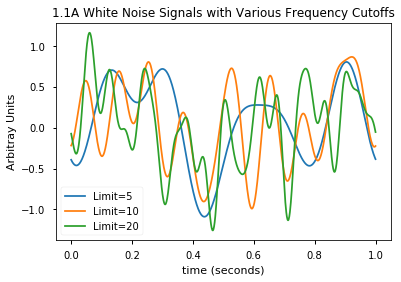

In [3]:
def generate_dropoff_signal(T,dt,rms,bandwidth,seed=0):
    
    if seed != 0:
        np.random.seed(seed=seed)
    
    t = np.arange(0,T,dt) #time scale
    N = len(t) #samples 
    # Need to reorder into linear scale
    f = np.fft.fftfreq(N,dt) #freq range (Hz)
    X = np.zeros(len(f)).tolist() #freq signal
    
    for i, freq in enumerate(f):
        stddev = np.exp(-np.power(freq,2)/(2*np.power(bandwidth,2)))
        if stddev != 0.0:
            real = np.random.normal(scale=stddev)
            imag = np.random.normal(scale=stddev)*1j
            X[i] = real + imag
            if -freq in f and freq != 0: #symmetric values
                X[i] = real - imag
    
    # rescale the signal to rms threshold
    x = np.fft.ifft(X).real
    sig_rms = calc_rms(x)
    
    x = [sig*(rms/sig_rms) for sig in x]
    X = np.fft.fft(x) #convert updated signal to freq domain
    
    return x, X


T = 1
dt = 0.001
N = int(T/dt)
rms = 0.5
time = np.linspace(0, T, N)

# bandwidth in radians 5*np.pi*2, 10*np.pi*2, 20*np.pi*2
x5, _ = generate_signal(T, dt, rms, 5, seed=5)
x10, _ = generate_signal(T, dt, rms, 10, seed=5)
x20, _ = generate_signal(T, dt, rms, 20, seed=5)


plt.figure()
plt.plot(time, x5, label='Limit=5')
plt.plot(time, x10, label='Limit=10')
plt.plot(time, x20, label='Limit=20')
plt.xlabel('time (seconds)')
plt.ylabel('Arbitray Units')
plt.title('1.1A White Noise Signals with Various Frequency Cutoffs')
plt.legend()

2. [1 mark] Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients) over 100 signals generated with ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``bandwidth``=10 (each of these 100 signals should have a different ``seed``).

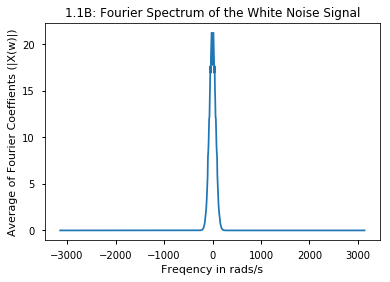

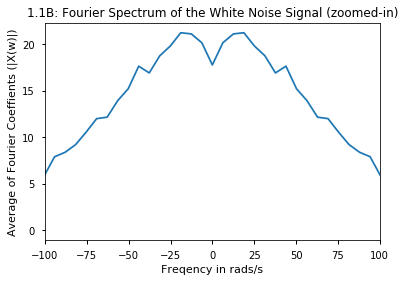

In [4]:
# time ranges and params
num_seeds = 100
t = np.arange(0, T, dt)
N = len(t) #samples
T, dt, rms, bandwidth = 1, 0.001, 0.1, 10

f = sorted(np.fft.fftfreq(N,dt)) #freqs (Hz)
w = [2*np.pi*freq for freq in f] #convert to radians

fourier_coefficients = np.zeros((N, 100))
X_sigs = []
for seed in range(num_seeds):
    x,X = generate_dropoff_signal(T=T,dt=dt,rms=rms,bandwidth=bandwidth,seed=seed)
    X_sigs.append(X)
    fourier_coefficients[:, seed] = np.abs(X)
    
    
mean_fourier_coeffients = np.mean(fourier_coefficients, axis=1)

X_sigs = np.array(X_sigs)
X_sigs_norm = [np.absolute(freq_vals) for freq_vals in X_sigs[:,]][0]

plt.figure()
plt.plot(w, np.fft.fftshift(mean_fourier_coeffients))
plt.xlabel('Freqency in rads/s')
plt.ylabel('Average of Fourier Coeffients (|X(w)|)')
plt.title('1.1B: Fourier Spectrum of the White Noise Signal')
plt.show()



# 1.1b figure zoomed in
plt.figure()
plt.plot(w, np.fft.fftshift(mean_fourier_coeffients))
plt.xlabel('Freqency in rads/s')
plt.ylabel('Average of Fourier Coeffients (|X(w)|)')
plt.title('1.1B: Fourier Spectrum of the White Noise Signal (zoomed-in)')
plt.xlim([-100, 100])
plt.show()

## 2) Simulating a Spiking Neuron

Write a program to simulate a single Leaky-Integrate and Fire neuron.  The core equation is $ {{dV} \over {dt}} = {1 \over {\tau_{RC}}} (J - V)$ (to simplify life, this is normalized so that $R$=1, the resting voltage is 0 and the firing voltage is 1).  This equation can be simulated numerically by taking  small time steps (Euler's method).  When the voltage reaches the threshold $1$, the neuron will spike and then reset its voltage to $0$ for the next $\tau_{ref}$ amount of time (to plot this, place a dot or line at that time).  Also, if the voltage goes below zero at any time, reset it back to zero.  For this question, $\tau_{RC}$=0.02 and $\tau_{ref}$=0.002

Since we want to do inputs in terms of $x$, we need to do $J = \alpha e \cdot x + J^{bias}$.  For this neuron, set $e$ to $+1$ and find $\alpha$ and $J^{bias}$ such that the firing rate when $x=0$ is 40Hz and when $x=1$ it is 150Hz.  To find these $\alpha$ and $J^{bias}$ values, use the approximation for the LIF neuron $a(J)={1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J})}}$.

In [5]:
class SpikingNeuron:
    def __init__(self, enc=1, tau_ref=0.002, tau_rc=0.02):
        self.min_rate = 40 # Hz, x = 0
        self.max_rate = 150 # Hz, x = {1,-1}; coincides with enc
        self.enc = enc
        self.tau_ref = tau_ref
        self.tau_rc = tau_rc
        
        self.j_bias = 1/(1-np.exp((self.tau_ref-(1/self.min_rate))/self.tau_rc))
        self.alpha = 1/(1-np.exp((self.tau_ref-(1/self.max_rate))/self.tau_rc))-self.j_bias
    
    def spikes(self, x, dt):
        spike_count = 0
        voltages = []
        v,i = 0,0
        while i < len(x):
            if v >= 1: #spike
                v = 1.5 #constant spike voltage
                spike_count +=1
                if len(voltages) < len(x): voltages.append(v)
                v = 0
                if len(voltages) < len(x): voltages.append(v)
                i=i+2
                continue
            else:    
                if len(voltages) < len(x): voltages.append(v)
            
            J = self.alpha*x[i]*self.enc + self.j_bias
            v = v + dt*(1/self.tau_rc)*(J - v)
            i += 1        
        return voltages, spike_count

Number of spikes: 40


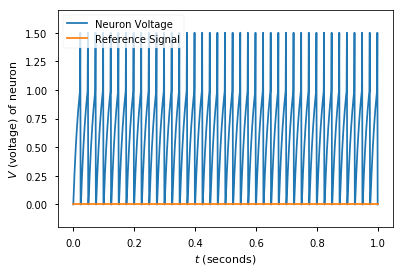

Number of spikes: 143


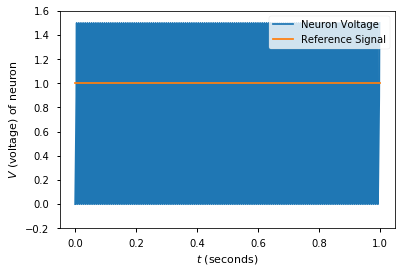

In [6]:
dt = 0.001
T = 1
t = np.arange(0,T,dt)
n = SpikingNeuron()

# Constant reference signal of x = 0
x = [0 for time in t]
spikes,num_spikes = n.spikes(x,dt)
# print(spikes)
print('Number of spikes:',num_spikes)

plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='Reference Signal')
plt.ylim(-0.2,1.7)
plt.xlabel('$t$ (seconds)')
plt.ylabel('$V$ (voltage) of neuron')
plt.legend()
plt.show()

# Constant reference signal of x = 1
x = [1 for time in t]
spikes,num_spikes = n.spikes(x,dt)
print('Number of spikes:',num_spikes)

plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='Reference Signal')
plt.ylim(-0.2,1.6)
plt.xlabel('$t$ (seconds)')
plt.ylabel('$V$ (voltage) of neuron')
plt.legend()
plt.show()

b. [1 mark] Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$?  Why or why not?  What aspects of the simulation would affect this accuracy?

### Explain Here

c. [1 mark] Plot the spike output for $x(t)$ generated using your function from part 1.1.  Use ``T``=1, ``dt``=0.001, ``rms``=0.5, and ``limit``=30.  Overlay on this plot $x(t)$.

Number of spikes: 53


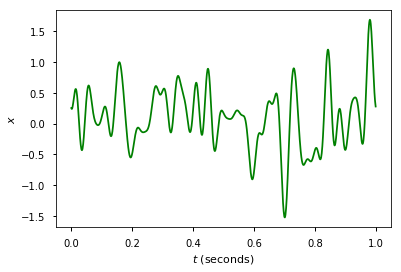

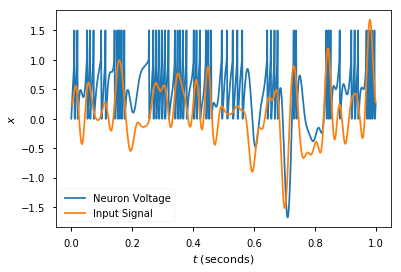

In [7]:
T, dt, rms, limit = 1, 0.001, 0.5, 30
x, X = generate_signal(T=T,dt=dt,rms=rms,limit=limit)
t = np.arange(0,T,dt)
n = SpikingNeuron()

# Randomly generated signal
spikes,num_spikes = n.spikes(x,dt)
print('Number of spikes:',num_spikes)

plt.plot(t, x, label='Input Signal',color='g')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$x$')
plt.show()

plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='Input Signal')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$x$')
plt.legend()
plt.show()

d. [1 mark] Using the same $x(t)$ signal as in part (c), plot the neuron's voltage over time for the first 0.2 seconds, along with the spikes over the same time.

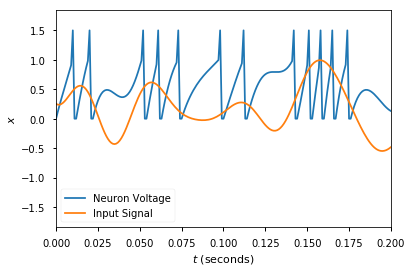

In [8]:
plt.plot(t, spikes, label='Neuron Voltage')
plt.plot(t, x, label='Input Signal')
plt.xlabel('$t$ (seconds)')
plt.ylabel('$x$')
plt.xlim(0.0,0.2)
plt.legend()
plt.show()

e. BONUS: How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time?  0.5 marks for having a good idea, and up to 1 marks for actually implementing it and showing that it works.

### Explain Here

## 3) Simulating Two Spiking Neurons

Write a program that simulates two neurons.  The two neurons have exactly the same parameters, except for one of them $e=1$ and for the other $e=-1$.  Other than that, use exactly the same settings as in question 2.

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at ~40 spikes per second).</li>
</ol>